In [1]:
import numpy as np
import pandas as pd 
import os 
import pickle 
from FE import age_feature, load_pkl

In [2]:
gender_enc = load_pkl('gender.pkl')
location_enc = load_pkl('location.pkl')
age_group_enc = load_pkl('age_group.pkl')

In [9]:
dfname = 'customer_churn_large_dataset.xlsx'
df = pd.read_excel(dfname)
df['Age_group'] = df.Age.apply(age_feature)
df['Age_group'] = age_group_enc.transform(df.Age_group)
df['Gender'] = gender_enc.transform(df.Gender)
df['Location'] = location_enc.transform(df.Location)
df.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Age_group
0,1,Customer_1,63,1,2,17,73.36,236,0,2
1,2,Customer_2,62,0,4,1,48.76,172,0,2
2,3,Customer_3,24,0,2,5,85.47,460,0,0
3,4,Customer_4,36,0,3,3,97.94,297,1,0
4,5,Customer_5,46,0,3,19,58.14,266,0,1


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
cols_to_drop = ['CustomerID', 'Name', 'Churn']
x = df.drop(cols_to_drop, axis = 1)
y = df.Churn

#### Train Val Test Split Distribution

> Train - 90% (90,000)

> Validation - 9% (9,000)

> Test - 1% (1,000)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .1, stratify = y)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = .1, stratify = y_test)

In [13]:
x_train.shape[0], x_val.shape[0], x_test.shape[0]

(90000, 9000, 1000)

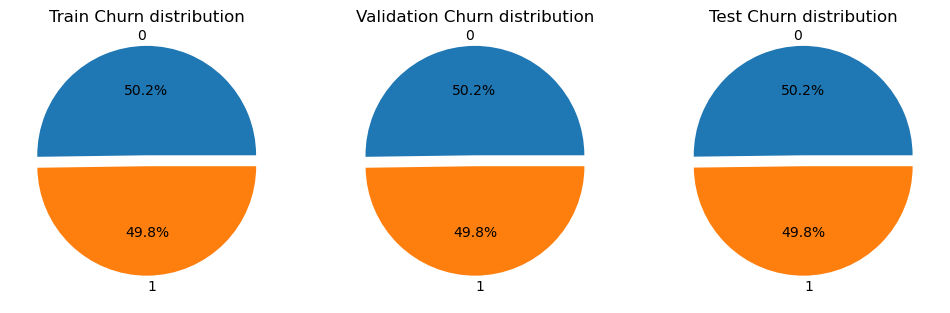

In [14]:
from cutils import plot_pie
import matplotlib.pyplot as plt 
from FE import save_pkl

plt.figure(figsize = (12, 6))
plt.tight_layout()

plt.subplot(1,3, 1)
plt.title('Train Churn distribution')
plot_pie(y_train, y_train.shape[0])

plt.subplot(1,3, 2)
plt.title('Validation Churn distribution')
plot_pie(y_val, y_val.shape[0])

plt.subplot(1,3, 3)
plt.title('Test Churn distribution')
plot_pie(y_test, y_test.shape[0])

In [15]:
# pd.concat([x_test, y_test], axis = 1).to_csv('test_churn_data.csv', index = False)

In [25]:
import time
import concurrent
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc

def show_metrics(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    re = recall_score(y_test, y_pred)
    print(pd.DataFrame({
        'Accuracy'  : [acc],
        'F1 score'  : [f1],
        'Precision' : [pr],
        'Recall'    : [re]
    }).T)

def train_models(train_data, val_data):
    
    X_train, y_train = train_data
    X_test, y_test = val_data
    algorithms = [LogisticRegression, SVC, GaussianNB, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, XGBClassifier]

    def train(Model) :
        pipe = Pipeline([('scaler', StandardScaler()), ('svc', Model())])
        model = pipe.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f' {Model.__name__} '.center(70, '='))
        show_metrics(y_test, y_pred)
        print()
        
    for Model in algorithms:
        start_time = time.time()
        train(Model)
        end_time = time.time()
        print(f'Training time : {(end_time - start_time) * 1000} ms')
        print(''.center(100, '='))

#### let's try to train multiple models and get the result with base parameters 

In [21]:
train_data = [x_train, y_train]
val_data = [x_val, y_val]
train_models(train_data, val_data)

========================= LogisticRegression =========================
                  0
Accuracy   0.496778
F1 score   0.380692
Precision  0.491352
Recall     0.310714

Training time : 42.861223220825195 ms
================================ SVC =================================
                  0
Accuracy   0.498778
F1 score   0.455127
Precision  0.495920
Recall     0.420536

Training time : 318272.3824977875 ms
============================= GaussianNB =============================
                  0
Accuracy   0.498111
F1 score   0.374983
Precision  0.493265
Recall     0.302455

Training time : 55.18841743469238 ms
======================= DecisionTreeClassifier =======================
                  0
Accuracy   0.502222
F1 score   0.495154
Precision  0.500000
Recall     0.490402

Training time : 735.2588176727295 ms
======================= RandomForestClassifier =======================
                  0
Accuracy   0.491778
F1 score   0.477377
Precision  0.488998
Recall     0

##### By averaging both accuracy and f1-score for all these above models, `Decision Tree` performed well compared to the rest

> Just like we figured out from EDA, we need more features to improve the accuracy of the model 

> No matter how many feature we engineer just from this data, we will only increase the multicolinearity between our independent features

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2],
}

xgb = XGBClassifier()
clf =  make_pipeline(StandardScaler(),
                      GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1))
clf.fit(x_train, y_train)

# best_params = pipe.best_params_
# best_score = pipe.best_score_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=3,
                              estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      i...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'gamma': [0, 0.1, 0.2],
                                          'learning_rate': [0.1, 0.01, 0.001],
                                          'max_depth': [3, 4, 5],
                                          'n_estimators': [100, 200, 300],
                                          'reg_alpha': [0, 0.1, 0.2],
                                          'reg_lambda': [0, 0.1, 0.2]},
                              scoring='accuracy'))])

In [38]:
clf.score(x_val, y_val)

0.504

In [39]:
from FE import save_pkl

save_pkl(clf, 'xgb_model.pkl')

Saved the data to pickles\xgb_model.pkl


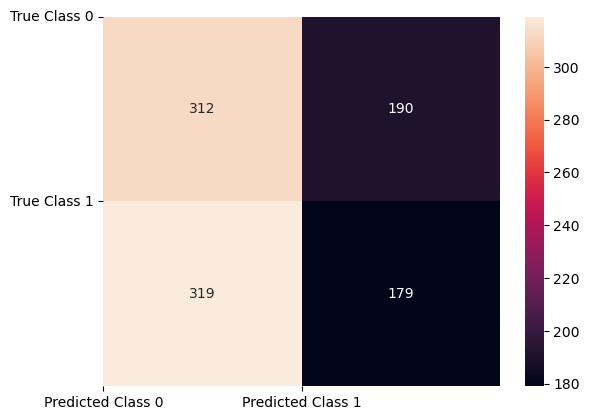

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, fmt = '.0f', annot = True)
plt.yticks(ticks=[0, 1], labels=['True Class 0', 'True Class 1'], rotation = 'horizontal')
plt.xticks(ticks=[0, 1], labels=['Predicted Class 0', 'Predicted Class 1']);